# Solving Burger's Equation with PINN

In [5]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import numpy as np
from tqdm import tqdm
torch.autograd.set_detect_anomaly(True)

## Define Neural Network

In [6]:
class PINN(nn.Module):
    
    def __init__(self, layers, optimizer=optim.Adam):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        
        # Define the layers
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            
        self.activation = nn.Tanh()

        self.optimizer = optimizer(self.parameters())


    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation(layer(x))
        return self.layers[-1](x)
    

    def u(self, x, t):
        u = self.forward(torch.cat([x, t], dim=1))
        return u


    def f(self, x, t):
        u = self.u(x, t)
        
        # Compute first derivative u_t and u_x with retain_graph=True to allow for u_xx computation
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        # Compute second derivative u_xx
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

        # Define the PDE residual
        f = u_t + u * u_x - (0.01 / np.pi) * u_xx
        return f
    

    def prepare_data(self, N_ic, N_bc, N_f):
        # N_ic = 100  # Number of initial condition points
        # N_bc = 50   # Number of boundary condition points
        # N_f = 10000 # Number of collocation points for PDE

        # Initial condition: u(0, x) = -sin(pi * x)
        self.x_ic = torch.linspace(-1, 1, N_ic).reshape(-1, 1)
        self.t_ic = torch.zeros_like(self.x_ic)
        self.u_ic = -torch.sin(np.pi * self.x_ic)

        # Boundary conditions: u(t, -1) = 0 and u(t, 1) = 0
        self.t_bc = torch.linspace(0, 1, 2*N_bc).reshape(-1, 1)
        self.x_bc = torch.cat([-torch.ones(N_bc), torch.ones(N_bc)], dim=0).reshape(-1, 1)
        self.u_bc = torch.zeros_like(self.x_bc)

        # Collocation points for PDE
        # x_f = torch.rand(N_f, 1, requires_grad=True)*2 - 1    # Random points in [-1, 1]
        # t_f = torch.rand(N_f, 1, requires_grad=True)          # Random points in [0, 1]

        # Collocation points for PDE (Sobel)
        sobel_engine = torch.quasirandom.SobolEngine(dimension=1, scramble=True)
        self.x_f = (sobel_engine.draw(N_f, dtype=torch.float32)*2 - 1).requires_grad_(True)
        self.t_f = (sobel_engine.draw(N_f, dtype=torch.float32)).requires_grad_(True)


    def compute_loss(self):

        # Initial condition loss
        u_ic_pred = self.u(self.x_ic, self.t_ic)
        ic_loss = torch.mean((u_ic_pred - self.u_ic)**2)

        # Boundary condition loss
        u_bc_pred = self.u(self.x_bc, self.t_bc)
        bc_loss = torch.mean((u_bc_pred - self.u_bc)**2)

        # PDE collocation loss
        f = self.f(self.x_f, self.t_f)
        f_loss = torch.mean(f**2)

        return ic_loss + bc_loss + f_loss
    

    def closure(self):
        self.optimizer.zero_grad()
        loss = self.compute_loss()
        loss.backward(retain_graph=True)
        self.progress_bar.set_postfix({'Loss': loss.item()})
        return loss
    

    def train(self, epochs=10000, use_gpu=True):
    
        # Prepare the data
        self.prepare_data(100, 50, 10000)

        # Check if GPU is available and use it if `use_gpu` is True
        device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
        if use_gpu and not torch.cuda.is_available():
            print("GPU is not available, training on CPU instead.")
        else:
            print(f"Training on {str(device).upper()}")
        self.to(device)
        
        # Move all tensors to the selected device
        self.x_ic, self.t_ic, self.u_ic = self.x_ic.to(device), self.t_ic.to(device), self.u_ic.to(device)
        self.x_bc, self.t_bc, self.u_bc = self.x_bc.to(device), self.t_bc.to(device), self.u_bc.to(device)
        self.x_f, self.t_f = self.x_f.to(device), self.t_f.to(device)

        # Initialize tqdm progress bar
        self.progress_bar = tqdm(range(epochs), desc="Training", unit="epoch")
        
        for _ in self.progress_bar:

            self.optimizer.step(self.closure)
        
        # Move the model back to the CPU
        self.to("cpu")
        
    

## Setup Training Loop

In [7]:
# Set parameters
layers = [2, 20, 20, 20, 1]  # Define layers (input layer + hidden layers + output layer)
optimizer = optim.Adam
model = PINN(layers, optimizer)
epochs = 10000
model.train()


Training on CUDA


Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training:   6%|▌         | 607/10000 [01:10<18:07,  8.64epoch/s, Loss=0.00943]


KeyboardInterrupt: 

## Evaluate Model

In [ ]:
# Save the model
torch.save(model.state_dict(), "../models/burgers/burgers.pth")

In [ ]:
# Load the model
model = PINN([2, 20, 20, 20, 1])
model.load_state_dict(torch.load("../models/burgers/burgers.pth"))

C:\Users\jonas\AppData\Local\Temp\ipykernel_3268\2352196097.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../models/burgers/burgers.p

<All keys matched successfully>

C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


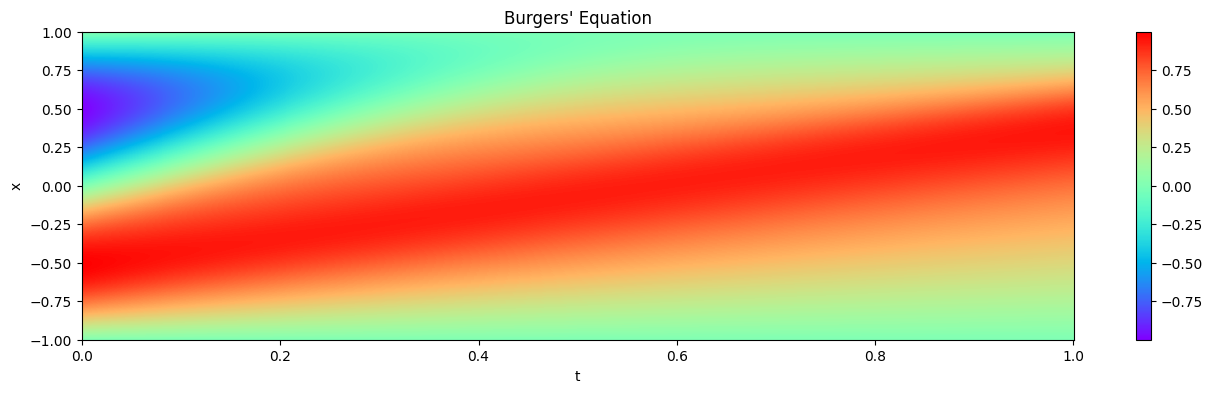

In [ ]:
# Evaluate the model on a grid
x = torch.linspace(-1, 1, 1000)
t = torch.linspace(0, 1, 1000)
X, T = torch.meshgrid(x, t)

u_pred = model.u(X.reshape(-1, 1), T.reshape(-1, 1)).reshape(X.shape).detach().numpy()

# Plot the results as a heatmap
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
plt.pcolor(T, X, u_pred, cmap="rainbow")
plt.colorbar()
plt.xlabel("t")
plt.ylabel("x")
plt.title("Burgers' Equation")
plt.show()

